In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.colors import ListedColormap

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Perceptron
from sklearn import datasets
from sklearn.metrics import accuracy_score

In [3]:
def plot_decision(X, y, clf, test_idx=None, resolution=.02):
    
    markers = ['x', 'o', 's', '^', 'v']
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors=colors[:len(np.unique(y))])
    
    xmin, xmax = X[:, 0].min()-1, X[:, 0].max()+1
    ymin, ymax = X[:, 1].min()-1, X[:, 1].max()+1
    XX = np.arange(xmin, xmax, resolution)
    YY = np.arange(ymin, ymax, resolution)
    XX, YY = np.meshgrid(XX, YY)
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
    
    plt.contourf(XX, YY, Z, cmap=cmap, alpha=.3)
    
    for i, c in enumerate(np.unique(y)):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=colors[i], marker=markers[i], label=c)
    
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black', 
                   alpha=1.0, linewidth=1, marker='o', s=100, label='test set')
    
    plt.legend(loc='best')

### Load Iris dataset

In [4]:
iris = datasets.load_iris()

In [5]:
X = iris.data[:, [2, 3]]   # patal length & petal width
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,stratify=y, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105, 2), (45, 2), (105,), (45,))

In [6]:
np.bincount(y_train), np.bincount(y_test), np.bincount(y)

(array([35, 35, 35]), array([15, 15, 15]), array([50, 50, 50]))

In [7]:
sc = StandardScaler()
sc.fit(X_train, y_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [9]:
X_combined = np.vstack((X_train_std, X_test_std))
y_combined = np.r_[y_train, y_test]

X_combined.shape, y_combined.shape

((150, 2), (150,))

### Sklearn: Perceptron

In [10]:
pct = make_pipeline(StandardScaler(), Perceptron(max_iter=30,eta0=.1, random_state=1))

In [11]:
pct.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('perceptron', Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      max_iter=30, n_iter=None, n_jobs=1, penalty=None, random_state=1,
      shuffle=True, tol=None, verbose=0, warm_start=False))])

In [12]:
pct.score(X_train, y_train), pct.score(X_test, y_test)

(0.91428571428571426, 0.93333333333333335)

In [13]:
a = pct.steps[1][1]

In [14]:
a.coef_

array([[-0.15674729, -0.10520175],
       [ 0.11096072, -0.26225649],
       [ 0.56537384,  0.25876639]])

In [15]:
accuracy_score(y_test, pct.predict(X_test))

0.93333333333333335

In [16]:
(y_test != pct.predict(X_test)).sum()

3

In [17]:
cross_val_score(pct, X_train, y_train, cv=5).mean()

0.92380952380952375

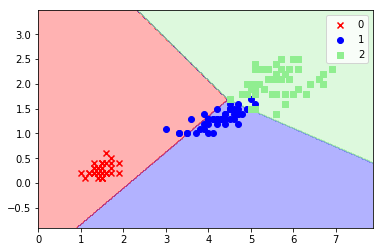

In [18]:
plot_decision(X, y, pct)

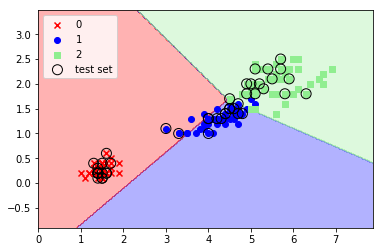

In [19]:
plot_decision(np.vstack([X_train, X_test]), np.r_[y_train, y_test], 
              pct, test_idx=range(len(X_train), len(X)))

### sklearn: LogisticRegression

In [20]:
class LogisticRegressionGD:
    '''Logistic Regression classifier using gradient descent
    
    Parameters
    ----------
    eta : float
        learning rate
    n_iter : int
        number of epochs
    random_state : int
        seed number for random generator
        
    Attributes
    ----------
    w_ : 1d-array
        Weights after fitting
    cost_ : list
        log-likelihood  cost function for each epoch
    '''
    def __init__(self, eta=0.05, n_iter=100, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        self.w_ = rng.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        
        self.cost_ = []
        for i in range(self.n_iter):
            output = self.activation(self.net_input(X))
            error = y - output
            self.w_[1:] += self.eta * np.dot(error, X)
            self.w_[0] += self.eta * error.sum()
            
            cost = np.dot(y, np.log(output)) + np.dot((1-y), np.log(1-output))
            self.cost_.append(-cost)
        return self
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)
    
    def net_input(self, X):
        '''calculate net input'''
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        '''sigmoid function'''
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

In [21]:
setosa = 0
versicolor = 1

X_seto_versi = X_train[(y_train == setosa) | (y_train == versicolor)]
y_seto_versi = y_train[(y_train==setosa)|(y_train==versicolor)]

In [22]:
X_seto_versi.shape, y_seto_versi.shape

((70, 2), (70,))

In [23]:
log_reg = LogisticRegressionGD(eta=.01, n_iter=500, random_state=1)

In [24]:
log_reg.fit(X_seto_versi, y_seto_versi)

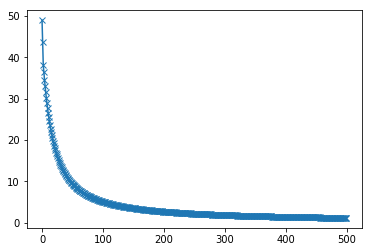

In [25]:
plt.plot(log_reg.cost_, 'x-')

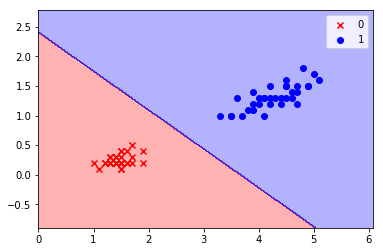

In [26]:
plot_decision(X_seto_versi, y_seto_versi, log_reg)

### Tranining a logistic regression model with scikit-learn

In [27]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [28]:
log_reg = LogisticRegressionCV(Cs=10**np.arange(-5, 6, dtype=float), cv=10, multi_class='multinomial')

In [29]:
log_reg.fit(X_train_std, y_train)

LogisticRegressionCV(Cs=array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04,   1.00000e+05]),
           class_weight=None, cv=10, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='multinomial',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [30]:
log_reg.score(X_train_std, y_train), log_reg.score(X_test_std, y_test)

(0.95238095238095233, 1.0)

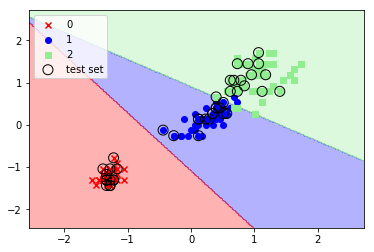

In [31]:
plot_decision(X_combined, y_combined, log_reg, test_idx=range(105, 150))

In [32]:
log_reg.C_

array([ 0.1,  0.1,  0.1])

In [33]:
lr = LogisticRegression(C=100.0, random_state=1).fit(X_train_std, y_train)

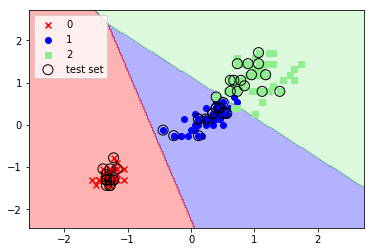

In [34]:
plot_decision(X_combined, y_combined, lr, test_idx=range(105, 150))

### Tackling overfitting via regularization

[]

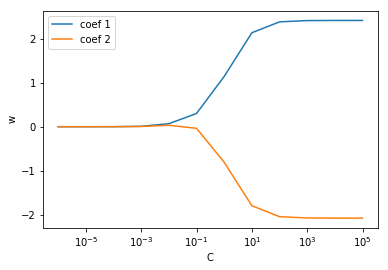

In [35]:
C_params = 10 ** np.arange(-6, 6, dtype=float)
coefs = []

for c in C_params:
    lr = LogisticRegression(C=c, penalty='l2', multi_class='ovr').fit(X_train_std, y_train)
    coefs.append(lr.coef_[1])
    
coefs = np.asarray(coefs)

plt.plot(C_params, coefs[:, 0], label='coef 1')
plt.plot(C_params, coefs[:, 1], label='coef 2')
plt.xlabel('C')
plt.ylabel('w')
plt.legend()
plt.semilogx()

### Maximum margin classification with support vector machines

In [36]:
from sklearn.svm import SVC

In [37]:
svm = SVC(kernel='linear', C=100.0, random_state=1)
svm.fit(X_train_std, y_train)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

Text(0.5,1,'C=1.0')

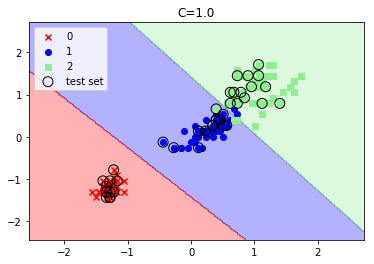

In [38]:
plot_decision(X_combined, y_combined, svm, range(105, 150))
plt.title('C=1.0')

In [39]:
svm.n_support_

array([2, 6, 6], dtype=int32)

### Solving nonlinear problems using a kernel SVM

In [41]:
np.random.seed(1)

X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)

In [43]:
y_xor = np.where(y_xor, 1, -1)

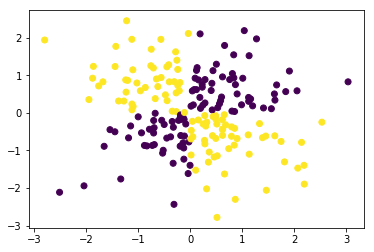

In [44]:
plt.scatter(X_xor[:, 0], X_xor[:, 1], c=y_xor)

In [50]:
svm = SVC(kernel='rbf', C=10, gamma=.01, random_state=1)
svm.fit(X_xor, y_xor)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

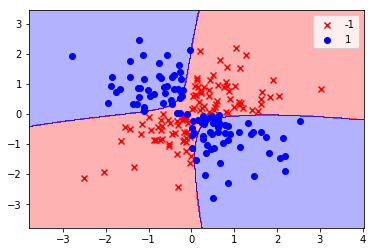

In [46]:
plot_decision(X_xor, y_xor, svm)

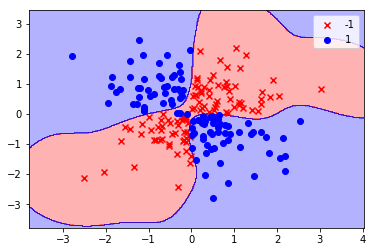

In [49]:
plot_decision(X_xor, y_xor, svm)

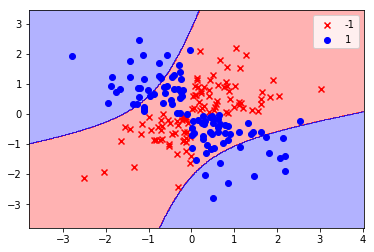

In [51]:
plot_decision(X_xor, y_xor, svm)

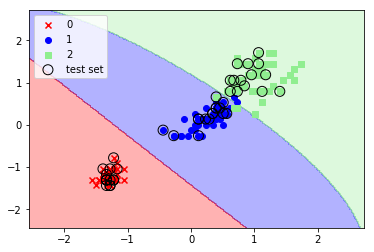

In [57]:
svm = SVC(kernel='rbf', C=10, gamma=.1)
svm.fit(X_train_std, y_train)

plot_decision(X_combined, y_combined, svm, range(105, 150))

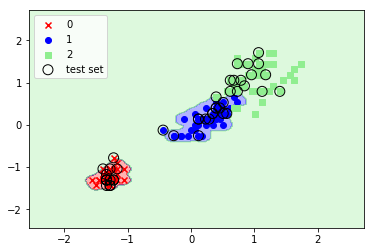

In [58]:
svm = SVC(kernel='rbf', C=10, gamma=100)
svm.fit(X_train_std, y_train)

plot_decision(X_combined, y_combined, svm, range(105, 150))

### Decision tree learning